In [ ]:
import requests
import pandas as pd
from google.colab import userdata

api_token=userdata.get('New_token')

# GitHub API URL
base_url = 'https://api.github.com'
headers = {'Authorization': f'token {api_token}'}

# Get users from Chennai with more than 50 followers
users_data=[]
page = 1
while True:
    users_url = f"{base_url}/search/users?q=location:Chennai+followers:>=50&page={page}&per_page=100"
    response = requests.get(users_url, headers=headers)
    data = response.json()
    if 'items' not in data or not data['items']:
        break
    users_data.extend(data['items'])
    page += 1

# Extract user info
users = []
for user in users_data:
    user_detail_url = user['url']
    user_response = requests.get(user_detail_url, headers=headers)
    user_info = user_response.json()

    # Clean up company name
    company = user_info.get('company', '')
    if company:
        company = company.strip().lstrip('@').upper()

    users.append({
        'login': user_info['login'],
        'name': user_info['name'],
        'company': company,
        'location': user_info['location'],
        'email': user_info['email'],
        'hireable': 'true' if user_info['hireable'] else 'false',
        'bio': user_info['bio'],
        'public_repos': user_info['public_repos'],
        'followers': user_info['followers'],
        'following': user_info['following'],
        'created_at': user_info['created_at']
        })

# Convert to DataFrame and save as CSV
users_df = pd.DataFrame(users)
users_df.to_csv('users.csv', index=False)

# Fetch repositories for each user
repos = []
for user in users:
    page = 1
    user_repos=[]
    while True:
        repos_url = f"{base_url}/users/{user['login']}/repos?sort=pushed&direction=desc&page={page}&per_page=100"
        # repos_url = f"{base_url}/users/{user['login']}/repos?per_page=100"
        repos_response = requests.get(repos_url, headers=headers)
        repos_data = repos_response.json()
        if not repos_data or len(user_repos) >= 500:
            break
        for repo in repos_data:
            if len(user_repos) >= 500:
                break
        # for repo in repos_data:
            user_repos.append({
                'login': user['login'],
                'full_name': repo['full_name'],
                'created_at': repo['created_at'],
                'stargazers_count': repo['stargazers_count'],
                'watchers_count': repo['watchers_count'],
                'language': repo['language'],
                'has_projects': 'true' if repo['has_projects'] else 'false',
                'has_wiki': 'true' if repo['has_wiki'] else 'false',
                'license_name': repo['license']['name'] if repo['license'] else None
            })
        page+=1
    repos.extend(user_repos)

# Convert to DataFrame and save as CSV
repos_df = pd.DataFrame(repos)
repos_df.to_csv('repositories.csv', index=False)



print("Data scraping and file creation completed.")
users_df.shape

Data scraping and file creation completed.


(432, 11)

In [4]:
users_df.columns

Index(['login', 'name', 'company', 'location', 'email', 'hireable', 'bio',
       'public_repos', 'followers', 'following', 'created_at'],
      dtype='object')

In [5]:
repos_df.shape,repos_df.columns

((26759, 9),
 Index(['login', 'full_name', 'created_at', 'stargazers_count',
        'watchers_count', 'language', 'has_projects', 'has_wiki',
        'license_name'],
       dtype='object'))

In [6]:
#Q1) Who are the top 5 users in Chennai with the highest number of followers?
# List their login in order, comma-separated.

top_5_followed =users_df.sort_values(by=['followers'],ascending=False).head(5)

top_5_login=','.join(top_5_followed['login'])
top_5_login

'Premalatha-success,anitaa1990,codewithMUHILAN,sygops,Spikeysanju'

In [7]:
#Q2) Who are the 5 earliest registered GitHub users in Chennai?
# List their login in ascending order of created_at, comma-separated.

early_5 = users_df.sort_values(by='created_at')

early_5_login=','.join(early_5.head(5)['login'])
early_5_login

'cnu,railsfactory,sudhirj,ravijaya,badri'

In [8]:
#Q3) What are the 3 most popular license among these users? Ignore missing licenses.
# List the license_name in order, comma-separated.

top_3_license=repos_df['license_name'].value_counts().head(3)

top_3_license_name=','.join(top_3_license.index)
top_3_license_name

'MIT License,Apache License 2.0,Other'

In [9]:
#Q4) Which company do the majority of these developers work at?
#users_df['company'].value_counts().sort_index(ascending=False).sort_values(ascending=False)
users_df['company'].value_counts().idxmax()

'CHENNAI INSTITUTE OF TECHNOLOGY'

In [10]:
#Q5) Which programming language is most popular among these users?
repos_df['language'].value_counts().idxmax()

'JavaScript'

In [11]:
#Q6) Which programming language is the second most popular among users who joined after 2020?

merged_df=pd.merge(users_df,repos_df,on='login') #to get language and joined date in same row

joined_after_2020=merged_df[merged_df['created_at_x']>'2020']

joined_after_2020['language'].value_counts().index[1]

'Python'

In [12]:
#Q7) Which language has the highest average number of stars per repository?

avg_lang_stars=repos_df.groupby('language')['stargazers_count'].mean()
avg_lang_stars.idxmax()

'Markdown'

In [13]:
#Q8) Let's define leader_strength as followers / (1 + following).
# Who are the top 5 in terms of leader_strength?
# List their login in order, comma-separated.

users_df['leader_strength']=users_df['followers']/(1+users_df['following'])
top_5_leaders=users_df.sort_values(by='leader_strength',ascending=False).head(5)
','.join(top_5_leaders['login'])

'codewithMUHILAN,Premalatha-success,aswintechguy,manikandanraji,jaganjavid'

In [14]:
#Q9) What is the correlation between the number of followers and the number of public repositories among users in Chennai?

users_df['followers'].corr(users_df['public_repos']).round(3)

0.085

In [15]:
#Q10) Does creating more repos help users get more followers?
# Using regression, estimate how many additional followers a user gets per additional public repository.

from sklearn.linear_model import LinearRegression

X=users_df[['public_repos']]
y=users_df['followers']

model=LinearRegression()
model.fit(X,y)
model.coef_[0].round(3)

0.302

In [16]:
#Q11) Do people typically enable projects and wikis together?
# What is the correlation between a repo having projects enabled and having wiki enabled?
repos_df[['has_projects','has_wiki']].corr()

,has_projects,has_wiki
has_projects,1.000000,0.221423
has_wiki,0.221423,1.000000


In [17]:
#Q12) Do hireable users follow more people than those who are not hireable?

hireable_users=users_df[users_df['hireable']==True]
non_hireable_users=users_df[users_df['hireable']==False]

# non_hireable_users=users_df[users_df['hireable']=='false']
# hireable_users=users_df[users_df['hireable']=='true']

hireable_following=hireable_users['following'].mean() #.round(3)
non_hireable_following=non_hireable_users['following'].mean() #.round(3)

round(hireable_following-non_hireable_following,3)

238.345

In [18]:
#Q13) Some developers write long bios.
# Does that help them get more followers?
# What's the correlation of the length of their bio (in Unicode characters) with followers? (Ignore people without bios)

import numpy as np
from sklearn.linear_model import LinearRegression

bio_notna=users_df[users_df['bio'].notna()].copy()

bio_notna.loc[:,'bios_length']=bio_notna['bio'].apply(lambda x:len(x.split()))


X=np.array(bio_notna['bios_length']).reshape(-1,1)
y=bio_notna['followers']

model=LinearRegression()
model.fit(X,y)

bio_notna['bios_length'].corr(bio_notna['following']).round(3)

model.coef_[0].round(3)

-1.701

In [19]:
#Q14) Who created the most repositories on weekends (UTC)?
#  List the top 5 users' login in order, comma-separated

repos_df['created_at'] = pd.to_datetime(repos_df['created_at'])

repos_df['created_on_weekend'] = repos_df['created_at'].dt.dayofweek.isin([5, 6])
weekend_repos_df = repos_df[repos_df['created_on_weekend']]

top_5_weekend_users=weekend_repos_df['login'].value_counts().head(5)
','.join(top_5_weekend_users.index)

'aasim-syed,nk-gears,karuppiah7890,rajasegar,TestLeafPages'

In [20]:
#Q15) Do people who are hireable share their email addresses more often?

users_df['has_email']=users_df['email'].notna()

hireable_with_email=users_df[users_df['hireable']==True]['has_email'].mean()
non_hireable_with_email=users_df[users_df['hireable']==False]['has_email'].mean()

round(hireable_with_email-non_hireable_with_email,4)

0.2596

In [21]:
#Q16) Let's assume that the last word in a user's name is their surname
#  (ignore missing names, trim and split by whitespace.)
#  What's the most common surname?
#  (If there's a tie, list them all, comma-separated, alphabetically)

from collections import Counter

users_with_names = users_df[users_df['name'].notna()].copy()
users_with_names.loc[:,'surname'] = users_with_names['name'].apply(lambda x: x.strip().split()[-1])

# users_with_names['surname'].value_counts().idxmax() # wont work incase of a tie

surname_counts=Counter(users_with_names['surname'])

max_count = max(surname_counts.values())
most_common_surnames = [surname for surname, count in surname_counts.items() if count == max_count]

','.join(most_common_surnames)

'S'

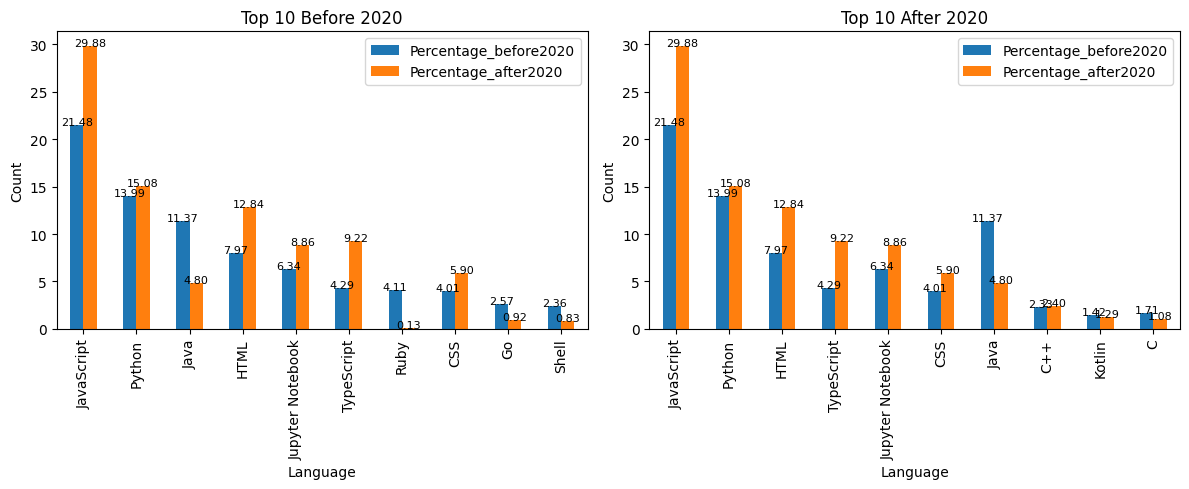

In [22]:
import matplotlib.pyplot as plt

joined_before_2020=merged_df[merged_df['created_at_x']<'2020']
df1=joined_before_2020['language'].value_counts()
df2=joined_after_2020['language'].value_counts()

# Merge the DataFrames
comparison_df = pd.merge(df1, df2, on='language', how='outer', suffixes=('_series1', '_series2')).fillna(0).sort_values(by=['count_series2','count_series1'],ascending=False)
# Calculate percentages
comparison_df['Percentage_before2020'] = (comparison_df['count_series1'] / comparison_df['count_series1'].sum()) * 100
comparison_df['Percentage_after2020'] = (comparison_df['count_series2'] / comparison_df['count_series2'].sum()) * 100
# Plotting
fig, (plt2,plt1)=plt.subplots(1,2,figsize=(12,5))

bars1=comparison_df[['Percentage_before2020','Percentage_after2020']][:10].plot(kind='bar',ax=plt1)
plt1.set_title('Top 10 After 2020')
plt1.set_xlabel('Language')
plt1.set_ylabel('Count')
# plt1.show()
for p in bars1.patches:
  bars1.annotate(str(f'{p.get_height():.2f}'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', fontsize=8)

Newcomparison_df=comparison_df.sort_values(by=['count_series1','count_series2'],ascending=False)
bars2=Newcomparison_df[['Percentage_before2020','Percentage_after2020']][:10].plot(kind='bar',ax=plt2)
plt2.set_title('Top 10 Before 2020')
plt2.set_xlabel('Language')
plt2.set_ylabel('Count')
# plt2.show()
for p in bars2.patches:
  bars2.annotate(str(f'{p.get_height():.2f}'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', fontsize=8)

plt.tight_layout()
plt.show()
# joined_after_2020.shape,joined_before_2020.shape,repos_df.shape
# comparison_df
# This indicates that JavaScript and HTML are becoming popular whereas Python and Java are used less compared to few years ago!
# JavaScript and HTML have started dominating since 2021 , while Java was overwhelmingly popular till 2020. Jupyter Notebook wasn't there in the frame until 2020, but since 2021 it has become the 4th popular language!

# Since 2021, JavaScript and HTML have taken the lead among the most popular language, while Java was dominant until 2020. Jupyter Notebook was absent until 2020 but has surged to become the 4th most popular language since 2021.